In [2]:
!pip install wandb
import json
!pip install ndjson
!mkdir -p quickdraw_data
import os
import wandb
import ndjson
import numpy as np
import pandas as pd
!pip install optuna
import optuna

import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

import cv2


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 20.9 MB/s eta 0:00:00


In [ ]:
# Les 10 premières catégories disponibles dans le dataset
categories = [
    # Animaux
    "ship",
    "bird",
    "camel",
    "cat",
    "dolphin",
    "crab",
    "fish",
    "flamingo",
    "hedgehog",
    "raccoon",
    "lion",
    "octopus",
    "whale",
    "shark",
    "rhinoceros",
    "rabbit",
    "pig",
    "crocodile",
    "cow",
    "elephant",

    # Objets
    "alarm%20clock",
    "anvil",
    "axe",
    "backpack",
    "baseball%20bat",
    "bed",
    "belt",
    "bicycle",
    "cell%20phone",
    "flip%20flops",
    "headphones",
    "tshirt",
    "flower",
    "eyeglasses",
    "harp",
    "hexagon",
    "key",
    "ladder",
    "knife",
    "fork",

    # Aliments
    "apple",
    "banana",
    "birthday%20cake",
    "blueberry",
    "bread",
    "broccoli",
    "carrot",
    "cookie",
    "donut",
    "grapes",
    "hamburger",
    "hot%20dog",
    "ice%20cream",
    "lollipop",
    "mushroom",
    "pear",
    "pineapple",
    "pizza",
    "strawberry",
    "watermelon",
]

# Création du dossier de données
os.makedirs("quickdraw_data", exist_ok=True)

# Téléchargement automatique via wget
for category in categories:
    url = f"https://storage.googleapis.com/quickdraw_dataset/full/simplified/{category}.ndjson"
    filename = f"quickdraw_data/{category}.ndjson"
    if not os.path.exists(filename):
        print(f"Téléchargement : {category}")
        !wget -q -O {filename} {url}
    else:
        print(f"Déjà téléchargé : {category}")


Téléchargement : ship
Téléchargement : bird
Téléchargement : camel
Téléchargement : cat
Téléchargement : dolphin
Téléchargement : crab
Téléchargement : fish
Téléchargement : flamingo
Téléchargement : hedgehog
Téléchargement : raccoon
Téléchargement : lion
Téléchargement : octopus
Téléchargement : whale
Téléchargement : shark
Téléchargement : rhinoceros
Téléchargement : rabbit
Téléchargement : pig
Téléchargement : crocodile
Téléchargement : cow
Téléchargement : elephant
Téléchargement : alarm%20clock
Téléchargement : anvil
^C
Téléchargement : axe
^C
Téléchargement : backpack
Téléchargement : baseball%20bat


In [ ]:
print(device)

cuda


In [ ]:
#Parser et convertir les 1000 premiers dessins reconnus des 10 catégories déjà téléchargées (en .ndjson)
# en images 28x28, et les stocker dans deux arrays : images (numpy) et labels (str).

# Fonction pour convertir un dessin (strokes) en image PIL 28x28
def draw_strokes(drawing, size=28, lw=3):
    img = Image.new("L", (256, 256), color=0)  # 256x256 pour avoir de la marge
    draw = ImageDraw.Draw(img)

    for stroke in drawing:
        points = list(zip(stroke[0], stroke[1]))
        draw.line(points, fill=255, width=lw)

    img = img.resize((size, size), Image.Resampling.LANCZOS)
    return np.array(img)



def dilate_image(img, kernel_size=2, iterations=1):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    return cv2.dilate(img, kernel, iterations=iterations)

def erode_image(img, kernel_size=2, iterations=1):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    return cv2.erode(img, kernel, iterations=iterations)


# Parser et convertir les 100 premiers dessins reconnus
images = []
labels = []

for category in categories:
    path = f"quickdraw_data/{category}.ndjson"
    try:
        with open(path) as f:
            data = ndjson.load(f)
    except FileNotFoundError:
        print(f"Fichier manquant pour {category}, ignoré.")
        continue

    count = 0
    for sample in data:
        if sample["recognized"]:
            img = draw_strokes(sample["drawing"])
            images.append(img)
            labels.append(category)
            count += 1
        if count >= 10000:  # Load 1000 samples per category
            break

images = np.array(images)
labels = np.array(labels)

print("Total images :", images.shape)
print("Total labels :", labels.shape)

Total images : (190000, 28, 28)
Total labels : (190000,)


In [ ]:
!pip install comet_ml
from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model

experiment = Experiment(
    api_key="zaG3cbShNIuBY5f3JXvcTMNJa",
    project_name="gribouillon",
    workspace="judale"
)
from datetime import datetime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.1/727.1 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 107.5 MB/s eta 0:00:00
  Attempting uninstall: python-box
    Found existing installation: python-box 7.3.2
    Uninstalling python-box-7.3.2:
      Successfully uninstalled python-box-7.3.2


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: tensorflow, torch, keras, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/judale/gribouillon/cc387a96cf9f4cb0a4ba9a264c600e34



# visualisations des fonctions d'érosions et dilatations

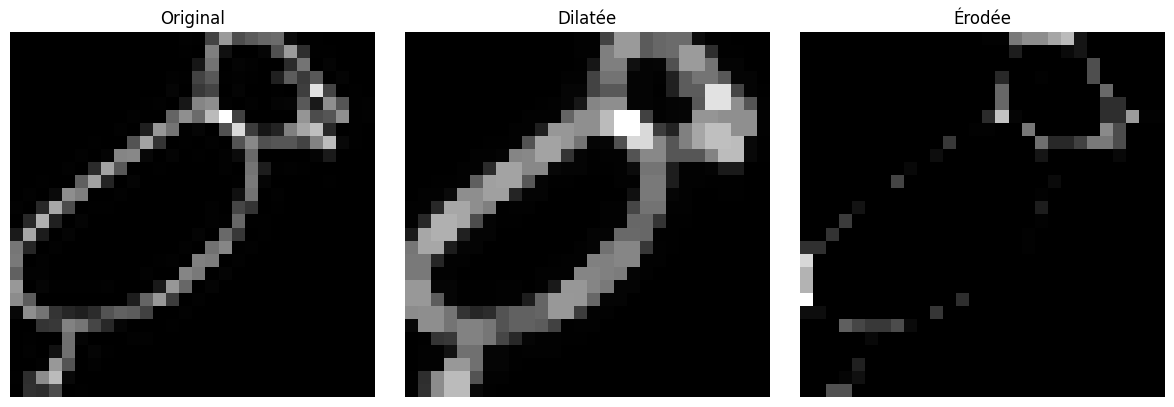

In [ ]:
import random


# Image originale
idx = random.randint(0, len(images) - 1)
original = images[idx]

# Application de la dilatation et de l’érosion
dilated = dilate_image(original, kernel_size=2)
eroded  = erode_image(original, kernel_size=2)

# Affichage
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(original, cmap='gray')
axs[0].set_title('Original')
axs[1].imshow(dilated, cmap='gray')
axs[1].set_title('Dilatée')
axs[2].imshow(eroded, cmap='gray')
axs[2].set_title('Érodée')
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()


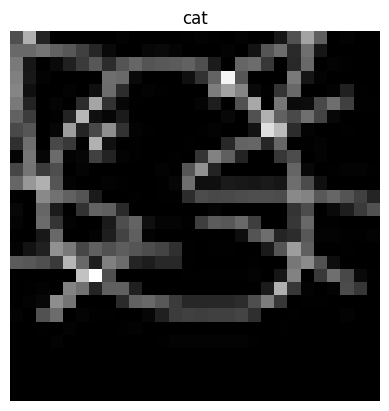

In [ ]:
#Visualisez une image random
import random

idx = random.randint(0, len(images) - 1)
plt.imshow(images[idx], cmap="gray")
plt.title(labels[idx])
plt.axis("off")
plt.show()

In [ ]:
# Normalisation : on ramène les valeurs des pixels entre 0 et 1
images = images.astype("float32") / 255.0
images = np.expand_dims(images, axis=1)  # PyTorch : (N, 1, 28, 28)

# Encodage des labels (ex: 'cat' -> 3, 'dog' -> 5, etc.)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

print("Catégories encodées :", list(label_encoder.classes_))
print("Nombre de classes :", len(label_encoder.classes_))


# Split des données
X_train, X_temp, y_train, y_temp = train_test_split(images, labels_encoded, test_size=0.2, stratify=labels_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Conversion en tenseurs
X_train = torch.tensor(X_train)
X_val   = torch.tensor(X_val)
X_test  = torch.tensor(X_test)

y_train = torch.tensor(y_train)
y_val   = torch.tensor(y_val)
y_test  = torch.tensor(y_test)

# Création des datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val, y_val)
test_dataset  = TensorDataset(X_test, y_test)

# Création des DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)

print("Données prêtes pour l'entraînement.")

#On a 8 classes alors qu'on devrait en avoir 10 il faut donc prendre la variable "classes" dans le modèle CNN pour être sûr de ne pas avoir des classes des fichiers .ndjson sont en erreur

Catégories encodées : [np.str_('bird'), np.str_('camel'), np.str_('cat'), np.str_('cow'), np.str_('crab'), np.str_('crocodile'), np.str_('dolphin'), np.str_('elephant'), np.str_('fish'), np.str_('flamingo'), np.str_('hedgehog'), np.str_('lion'), np.str_('octopus'), np.str_('pig'), np.str_('rabbit'), np.str_('raccoon'), np.str_('rhinoceros'), np.str_('shark'), np.str_('whale')]
Nombre de classes : 19
Données prêtes pour l'entraînement.


In [ ]:
# CNN simple avec PyTorch, inspiré de LeNet-5, adapté aux images 28×28 en niveaux de gris
class BetterCNN(nn.Module):
    def __init__(self, num_classes):
        super(BetterCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # (1, 28, 28) -> (32, 28, 28)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # (32, 28, 28)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (32, 14, 14)
            nn.Dropout(0.3),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # (64, 14, 14)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (64, 7, 7)
            nn.Dropout(0.3006002871157536),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3006002871157536),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


model = BetterCNN(num_classes=len(label_encoder.classes_))

In [ ]:
# Transforme les tableaux images et labels en un Dataset PyTorch, puis les séparer en train, val et test

class QuickDrawDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transforms.Compose([
               transforms.ToPILImage(),
               transforms.RandomRotation(10),  # Rotation aléatoire de 10 degrés
               transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Translation aléatoire
               transforms.ToTensor()
           ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # The line below was causing the problem
        # image = torch.tensor(image).unsqueeze(0)  # Shape: (1, 28, 28)
        # We already have (1, 28, 28) from previous opera*=tions
        image = torch.tensor(image)  # Keep the original image shape (1, 28, 28)
        label = torch.tensor(label).long()

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
# Séparation train/val/test

# Encodage des labels texte en entiers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)

# Split 80% train, 10% val, 10% test
# Use labels_np instead of labels_encoded for stratify
X_train, X_temp, y_train, y_temp = train_test_split(images, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 152000, Val: 19000, Test: 19000


In [ ]:
# Création des DataLoader
batch_size = 64

train_dataset = QuickDrawDataset(X_train, y_train)
val_dataset = QuickDrawDataset(X_val, y_val)
test_dataset = QuickDrawDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# Initialisation de l’entraînement - Définir modèle, loss et optimizer
model = BetterCNN(num_classes=len(label_encoder.classes_)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # L2 regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1)  # Reduce LR if val loss plateaus

In [ ]:
# Intégration avec Weights & Biases - Initialisation comet

lr=0.001
num_epochs = 50

experiment.set_name(f"Modèle classe animaux")

experiment.log_parameters({
    "learning_rate": lr,
    "batch_size": batch_size,
    "epochs": num_epochs,
    "num_classes": len(set(labels))
})

In [ ]:
# boucle entrainement

best_val_acc = 0
patience = 2
wait = 0

train_accs, val_accs = [], []

for epoch in range(50):
    model.train()
    correct = total = 0
    train_loss = 0 # Initialize train_loss for each epoch
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0) # Accumulate loss
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader.dataset) # Calculate average train loss
    train_acc = 100 * correct / total
    train_accs.append(train_acc)

    model.eval()
    correct = total = 0
    val_loss = 0 # Initialize val_loss for each epoch
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels) # Calculate loss for validation
            val_loss += loss.item() * images.size(0) # Accumulate loss
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader.dataset) # Calculate average validation loss
    val_acc = 100 * correct / total
    val_accs.append(val_acc)

    print(f"[{epoch+1}/20] Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
    experiment.log_metric("train_loss", train_loss, step=epoch)
    experiment.log_metric("val_loss", val_loss, step=epoch)
    experiment.log_metric("train_acc", train_acc, step=epoch)
    experiment.log_metric("val_acc", val_acc, step=epoch)

    scheduler.step(val_loss) # Step the scheduler with validation loss

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        wait = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping.")
            break

[1/20] Train Acc: 60.25% | Val Acc: 73.23%
[2/20] Train Acc: 70.36% | Val Acc: 77.45%
[3/20] Train Acc: 73.11% | Val Acc: 78.83%
[4/20] Train Acc: 74.86% | Val Acc: 80.10%
[5/20] Train Acc: 75.69% | Val Acc: 81.19%
[6/20] Train Acc: 76.39% | Val Acc: 81.67%
[7/20] Train Acc: 76.96% | Val Acc: 82.34%
[8/20] Train Acc: 77.53% | Val Acc: 82.57%
[9/20] Train Acc: 77.87% | Val Acc: 83.12%
[10/20] Train Acc: 78.31% | Val Acc: 82.82%
[11/20] Train Acc: 78.51% | Val Acc: 83.31%
[12/20] Train Acc: 78.84% | Val Acc: 83.18%
[13/20] Train Acc: 79.03% | Val Acc: 83.32%
[14/20] Train Acc: 79.02% | Val Acc: 83.47%
[15/20] Train Acc: 79.42% | Val Acc: 83.92%
[16/20] Train Acc: 79.47% | Val Acc: 84.06%
[17/20] Train Acc: 79.59% | Val Acc: 83.72%
[18/20] Train Acc: 79.76% | Val Acc: 84.31%
[19/20] Train Acc: 79.93% | Val Acc: 84.20%
[20/20] Train Acc: 80.21% | Val Acc: 84.11%
Early stopping.


In [ ]:
# Évaluation sur le test set

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")
experiment.log_metric("test_accuracy", test_acc)
log_model(experiment, model, model_name="CNN_QuickDraw")

# fonction d’affichage de courbes

def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train")
    plt.plot(history.history["val_accuracy"], label="Val")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train")
    plt.plot(history.history["val_loss"], label="Val")
    plt.title("Loss")
    plt.legend()
    plt.show()


Test Accuracy: 84.42%


In [ ]:
#  Sauvegarde du modèle entraîné (.pth)

model_path = "quickdraw_animal.pth"
torch.save(model.state_dict(), model_path)
print(f"Modèle sauvegardé dans {model_path}")

Modèle sauvegardé dans quickdraw_animal.pth


In [ ]:
# Arrêt du tracking Weights & Biases

wandb.finish()

In [ ]:
def train_model(model, optimizer, train_loader, val_loader, criterion, epochs=3):
    model.to(device)
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

        # Évaluation validation
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                outputs = model(x_val)
                _, predicted = torch.max(outputs, 1)
                total += y_val.size(0)
                correct += (predicted == y_val).sum().item()

        acc = correct / total
        if acc > best_acc:
            best_acc = acc
    return best_acc


def objective(trial):
    # Paramètres Optuna à tester
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.3, 0.7)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    # Conversion numpy -> torch.tensor
    X_train_tensor = torch.tensor(X_train).float()
    y_train_tensor = torch.tensor(y_train).long()
    X_val_tensor   = torch.tensor(X_val).float()
    y_val_tensor   = torch.tensor(y_val).long()

    # Création des jeux de données
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Définition du modèle (exemple CNN simple avec dropout variable)
    class TunedCNN(nn.Module):
        def __init__(self):
            super(TunedCNN, self).__init__()
            self.features = nn.Sequential(
                nn.Conv2d(1, 32, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(32, 32, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Dropout(dropout),

                nn.Conv2d(32, 64, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(64, 64, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Dropout(dropout),
            )
            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(64 * 7 * 7, 128),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(128, len(label_encoder.classes_))  # nombre de classes
            )

        def forward(self, x):
            x = self.features(x)
            x = self.classifier(x)
            return x

    model = TunedCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Entraînement rapide (3 epochs max pour Optuna)
    best_acc = 0
    for epoch in range(3):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

        # Évaluation sur validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                _, predicted = torch.max(outputs, 1)
                total += yb.size(0)
                correct += (predicted == yb).sum().item()

        acc = correct / total
        if acc > best_acc:
            best_acc = acc

    return best_acc

In [ ]:
print("Type de X_train :", type(X_train))
print("Shape de X_train :", getattr(X_train, 'shape', 'no shape'))
print("Type de y_train :", type(y_train))
print("Shape de y_train :", getattr(y_train, 'shape', 'no shape'))


Type de X_train : <class 'numpy.ndarray'>
Shape de X_train : (152000, 1, 28, 28)
Type de y_train : <class 'numpy.ndarray'>
Shape de y_train : (152000,)


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best accuracy:", study.best_value)
print("Best params:", study.best_params)


[I 2025-05-27 08:23:51,078] A new study created in memory with name: no-name-ce1ef47d-061b-4716-8d4d-e1b93b72a799
[I 2025-05-27 08:24:24,280] Trial 0 finished with value: 0.7072631578947368 and parameters: {'lr': 0.0002855339397042051, 'dropout': 0.6457111584222855, 'batch_size': 64}. Best is trial 0 with value: 0.7072631578947368.
[I 2025-05-27 08:24:52,699] Trial 1 finished with value: 0.6954210526315789 and parameters: {'lr': 0.0003220008646002111, 'dropout': 0.6119663877229842, 'batch_size': 128}. Best is trial 0 with value: 0.7072631578947368.
[I 2025-05-27 08:25:41,557] Trial 2 finished with value: 0.7622631578947369 and parameters: {'lr': 0.0003245772338030808, 'dropout': 0.4960566590800759, 'batch_size': 32}. Best is trial 2 with value: 0.7622631578947369.
[I 2025-05-27 08:26:09,194] Trial 3 finished with value: 0.05263157894736842 and parameters: {'lr': 0.00775159771137797, 'dropout': 0.3333417698816321, 'batch_size': 128}. Best is trial 2 with value: 0.7622631578947369.
